## INIZIALIZATION

In [1]:
import numpy as np
import time
from tqdm.auto import tqdm


problems = [{}]

solutions = np.empty(3, dtype=object)
fitness_history = [[] for _ in range(3)]  # Store fitness improvements for each problem

MAX_STEPS=1685

# Random initialization constants  
DELAY=0.085 # every DELAY seconds (N_ITEMS / STEPS) are set unassigned
STEPS=10

# Simulated Annealing parameters
INITIAL_TEMP=10000  # Starting temperature
FINAL_TEMP=1        # Minimum temperature 

COOLING_RATE=0.995  # Exponential cooling factor (0.9-0.999)

# with this configuration it should take around 5 minutes to solve all the problems

# KNAPSACKS PROBLEMS

### Problem 1:

In [2]:
rng = np.random.default_rng(seed=42)
problems[0] = {
    "NUM_KNAPSACKS": 3,
    "NUM_ITEMS": 20,
    "NUM_DIMENSIONS": 2
}
problems[0]["VALUES"] = rng.integers(0, 100, size=problems[0]["NUM_ITEMS"])
problems[0]["WEIGHTS"] = rng.integers(0, 100, size=(problems[0]["NUM_ITEMS"], problems[0]["NUM_DIMENSIONS"]))
problems[0]["CONSTRAINTS"] = rng.integers(0, 100 * problems[0]["NUM_ITEMS"] // problems[0]["NUM_KNAPSACKS"], size=(problems[0]["NUM_KNAPSACKS"], problems[0]["NUM_DIMENSIONS"]))


### Problem 2:

In [3]:
rng = np.random.default_rng(seed=42)
problems.append({})
problems[1] = {
    "NUM_KNAPSACKS": 10,
    "NUM_ITEMS": 100,
    "NUM_DIMENSIONS": 10
}
problems[1]["VALUES"] = rng.integers(0, 1000, size=problems[1]["NUM_ITEMS"])
problems[1]["WEIGHTS"] = rng.integers(0, 1000, size=(problems[1]["NUM_ITEMS"], problems[1]["NUM_DIMENSIONS"]))
problems[1]["CONSTRAINTS"] = rng.integers(1000 * 2, 1000 * problems[1]["NUM_ITEMS"] // problems[1]["NUM_KNAPSACKS"], size=(problems[1]["NUM_KNAPSACKS"], problems[1]["NUM_DIMENSIONS"]))

### Problem 3:

In [4]:
rng = np.random.default_rng(seed=42)
problems.append({})
problems[2] = {
    "NUM_KNAPSACKS": 100,
    "NUM_ITEMS": 5000,
    "NUM_DIMENSIONS": 100
}
problems[2]["VALUES"] = rng.integers(0, 1000, size=problems[2]["NUM_ITEMS"])
problems[2]["WEIGHTS"] = rng.integers(0, 1000, size=(problems[2]["NUM_ITEMS"], problems[2]["NUM_DIMENSIONS"]))
problems[2]["CONSTRAINTS"] = rng.integers(1000 * 10, 1000 * 2 * problems[2]["NUM_ITEMS"] // problems[2]["NUM_KNAPSACKS"], size=(problems[2]["NUM_KNAPSACKS"], problems[2]["NUM_DIMENSIONS"]))

## Elaboration:

In [5]:
def solve_knapsack(problem, problem_id=0): #i treat all knapsacks together

    main_rng = np.random.default_rng(seed=int(time.time() * 1000000000))

    def check_constraints(solution):
        total_weights = np.zeros((problem["NUM_KNAPSACKS"], problem["NUM_DIMENSIONS"]), dtype=int)
        
        # Iterate through items and accumulate weights for assigned knapsacks
        for i, knapsack_id in enumerate(solution):
            if knapsack_id >= 0:  # -1 means unassigned, 0+ means knapsack index 
                for d in range(problem["NUM_DIMENSIONS"]):
                    total_weights[knapsack_id, d] += problem["WEIGHTS"][i, d]
        
        return np.all(total_weights <= problem["CONSTRAINTS"])

    # Create random assignment: -1 = unassigned, 0,1,2,... = knapsack index
    def random_starting_solution(n_knapsack, n_items):
        forced_unassigned = set()  # Set to track positions to force to -1 (unassigned)
        last_time = time.time()
        
        while True:
            solution = main_rng.integers(-1, n_knapsack, size=n_items)
            
            for pos in forced_unassigned:
                solution[pos] = -1

            #it will exit at least with the solution without assignements
            if check_constraints(solution):     
                break
            
            current_time = time.time()
            if current_time - last_time >= DELAY: 
                random_positions = main_rng.integers(0, n_items, size=n_items // STEPS)
                forced_unassigned.update(random_positions)  
                last_time = current_time
                
        return solution

    def vector_to_matrix(item_assignments):
        matrix = np.zeros((problem["NUM_KNAPSACKS"], problem["NUM_ITEMS"]), dtype=int)
        for i, knapsack_id in enumerate(item_assignments):
            if knapsack_id >= 0:  
                matrix[knapsack_id, i] = 1  
        return matrix

    def tweak(solution):
        while True:
            new_solution = solution.copy()
            i = main_rng.integers(0, problem["NUM_ITEMS"])
            new_solution[i] = main_rng.integers(-1, problem["NUM_KNAPSACKS"])
            
            if check_constraints(new_solution):
                return new_solution

    def fitness(solution):
        total_value = 0
        for i, knapsack_id in enumerate(solution):
            if knapsack_id >= 0:  
                total_value += problem["VALUES"][i]
        return total_value

    solution = random_starting_solution(problem["NUM_KNAPSACKS"], problem["NUM_ITEMS"])
    
    # Track initial fitness
    current_fitness = fitness(solution)
    fitness_history[problem_id].append(current_fitness)
    
    # Initialize temperature for simulated annealing
    temperature = INITIAL_TEMP
    
    # Progress bar for optimization steps
    progress_bar = tqdm(range(MAX_STEPS), desc=f"Problem {problem_id+1} Optimization", 
                       unit="steps", leave=True)
    
    step = 0
    for step in progress_bar:
        new_solution = tweak(solution)  # Always returns valid solution
        new_fitness = fitness(new_solution)
        
        if new_fitness >= current_fitness:
            solution = new_solution
            current_fitness = new_fitness
            fitness_history[problem_id].append(current_fitness)
            # Update progress bar description with current fitness
            progress_bar.set_postfix({"Fitness": current_fitness, "Temp": f"{temperature:.1f}"})
        else:
            # Simulated annealing acceptance with cooling temperature
            delta = current_fitness - new_fitness
            acceptance_prob = np.exp(-delta / max(temperature, FINAL_TEMP))
            if main_rng.random() < acceptance_prob:
                solution = new_solution
                current_fitness = new_fitness
                fitness_history[problem_id].append(current_fitness)
                progress_bar.set_postfix({"Fitness": current_fitness, "Temp": f"{temperature:.1f}", "Accepted": "Worse"})
        
        # Cool down temperature (exponential cooling)
        temperature = max(FINAL_TEMP, temperature * COOLING_RATE)

    # Convert back to 2D matrix for return (to match expected output format)
    return vector_to_matrix(solution)

In [6]:
i=0
for problem in problems :
    #print(problem)
    #print (i)
    solutions[i] = solve_knapsack(problem, problem_id=i)
    print(f"Problem {i+1}: Final fitness = {fitness_history[i][-1]}, Improvements = {len(fitness_history[i])}")
    #print(solutions[i] )
    i += 1


Problem 1 Optimization:   0%|          | 0/1685 [00:00<?, ?steps/s]

Problem 1: Final fitness = 1065, Improvements = 1417


Problem 2 Optimization:   0%|          | 0/1685 [00:00<?, ?steps/s]

Problem 2: Final fitness = 43237, Improvements = 1275


Problem 3 Optimization:   0%|          | 0/1685 [00:00<?, ?steps/s]

Problem 3: Final fitness = 1097684, Improvements = 1670


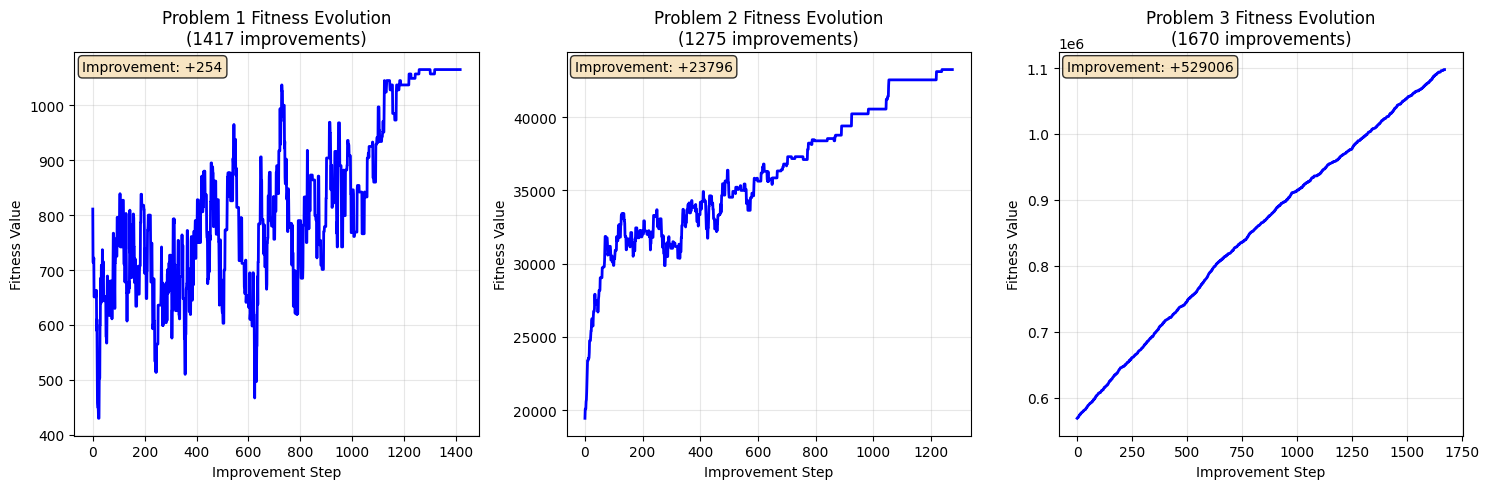


Fitness Evolution Summary:
Problem 1:
  Initial fitness: 811
  Final fitness: 1065
  Total improvements: 1416
  Net improvement: +254
Problem 2:
  Initial fitness: 19441
  Final fitness: 43237
  Total improvements: 1274
  Net improvement: +23796
Problem 3:
  Initial fitness: 568678
  Final fitness: 1097684
  Total improvements: 1669
  Net improvement: +529006


In [7]:
# Plot fitness improvements for each problem
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    if len(fitness_history[i]) > 0:
        plt.plot(fitness_history[i], 'b-', linewidth=2)
        plt.title(f'Problem {i+1} Fitness Evolution\n({len(fitness_history[i])} improvements)')
        plt.xlabel('Improvement Step')
        plt.ylabel('Fitness Value')
        plt.grid(True, alpha=0.3)
        
        # Add some stats
        initial_fitness = fitness_history[i][0] if len(fitness_history[i]) > 0 else 0
        final_fitness = fitness_history[i][-1] if len(fitness_history[i]) > 0 else 0
        improvement = final_fitness - initial_fitness
        plt.text(0.02, 0.98, f'Improvement: +{improvement}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        plt.title(f'Problem {i+1}: No improvements recorded')
        plt.text(0.5, 0.5, 'No data', ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFitness Evolution Summary:")
for i in range(3):
    if len(fitness_history[i]) > 0:
        print(f"Problem {i+1}:")
        print(f"  Initial fitness: {fitness_history[i][0]}")
        print(f"  Final fitness: {fitness_history[i][-1]}")
        print(f"  Total improvements: {len(fitness_history[i]) - 1}")
        print(f"  Net improvement: +{fitness_history[i][-1] - fitness_history[i][0]}")
    else:
        print(f"Problem {i+1}: No fitness data recorded")